## Analyses in [Prasad et al. 2020](http://bossdb.org/project/prasad2020)


- Please run the cells in order, as cells lower down might depend on those which come before.
- This notebook uses functions defined in the file **helper.py** - So make sure it's in the same folder as this notebook!
- Dependencies used in this notebook are [numpy](https://pypi.org/project/numpy/), [matplotlib](https://pypi.org/project/matplotlib/), [seaborn](https://pypi.org/project/seaborn/), [pandas](https://pypi.org/project/pandas/), [scipy](https://pypi.org/project/scipy/) and [sklearn](https://pypi.org/project/scikit-learn/)  - All of which can be installed via pip

Note: If you get the following error when running the next cell, *ImportError: cannot import name 'remove_na'*, try to uninstall and reinstall seaborn.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from numpy.linalg import norm
from scipy.stats import entropy
from sklearn.metrics import classification_report

from statannot import add_stat_annotation
sns.set(style="whitegrid") ## comment out to not have a "grid"

from helper import *
import warnings
warnings.filterwarnings('ignore')

### 1. Load images and pixel-level annotations from ROIs

In [2]:
## Train imgs and masks
train_imgs_ctx = np.load('data/imgs_ctx.npz')['arr_0']
train_masks_ctx = np.load('data/masks_ctx.npz')['arr_0']

train_imgs_str = np.load('data/imgs_str.npz')['arr_0']
train_masks_str = np.load('data/masks_str.npz')['arr_0']

train_imgs_trn = np.load('data/imgs_trn.npz')['arr_0']
train_masks_trn = np.load('data/masks_trn.npz')['arr_0']

train_imgs_zi = np.load('data/imgs_zi.npz')['arr_0']
train_masks_zi = np.load('data/masks_zi.npz')['arr_0']

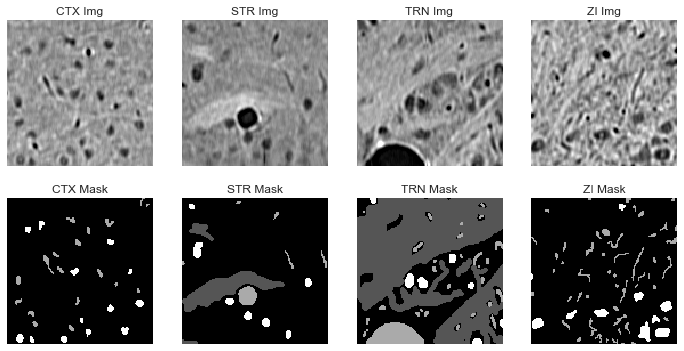

In [3]:
plotImgs_masks()

### 2. Pixel intensity histograms across ROIs (Fig. 2B)

In [4]:
bins = [x/255 for x in range(257)]

hist_ctx,b = np.histogram(train_imgs_ctx, bins=bins)
hist_str,b = np.histogram(train_imgs_str, bins=bins)
hist_trn,b = np.histogram(train_imgs_trn, bins=bins)
hist_zi,b = np.histogram(train_imgs_zi, bins=bins)

Text(0, 0.5, 'Avg. Counts/Image')

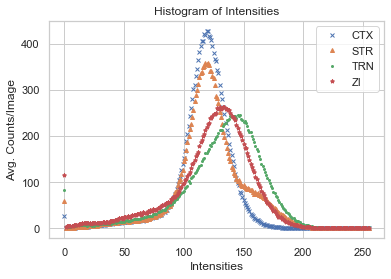

In [5]:
ticks = np.array([str(np.around(j,4)) for j in bins])

f = plt.figure()

plt.plot(hist_ctx/32,'x',markersize=4,label='CTX')
plt.plot(hist_str/32,'^',markersize=4,label='STR')
plt.plot(hist_trn/32,'.',markersize=4,label='TRN')
plt.plot(hist_zi/32,'*',markersize=4,label='ZI')

plt.legend()
plt.title('Histogram of Intensities')
plt.xlabel('Intensities')
plt.ylabel('Avg. Counts/Image')

### 3. Distributions of microstructure across ROIs (Fig. 2C)

In [6]:
bins_annos = [0,1,2,3,4]

hist_ctx_annos,b = np.histogram(train_masks_ctx, bins=bins_annos)
hist_str_annos,b = np.histogram(train_masks_str, bins=bins_annos)
hist_trn_annos,b = np.histogram(train_masks_trn, bins=bins_annos)
hist_zi_annos,b = np.histogram(train_masks_zi, bins=bins_annos)

In [7]:
hist_all_areas = np.vstack((hist_ctx_annos,
                            hist_zi_annos,
                            hist_str_annos,
                            hist_trn_annos,))

In [8]:
hist_all_areas_composition = hist_all_areas/np.sum(hist_all_areas,axis=1)

In [9]:
data = {"Component":['Blood Vessels','Cells','Axons',
                    'Blood Vessels','Cells','Axons',
                    'Blood Vessels','Cells','Axons',
                    'Blood Vessels','Cells','Axons'],
         "Region of Interest (ROI)":["CTX","CTX","CTX",
                                     "ZI","ZI","ZI",
                                     "STR","STR","STR",
                                     "TRN","TRN","TRN"],
         "Fraction of Pixels":[hist_all_areas_composition[0,2],
                               hist_all_areas_composition[0,3],hist_all_areas_composition[0,1],
                               
                               hist_all_areas_composition[1,2],
                               hist_all_areas_composition[1,3],hist_all_areas_composition[1,1],
                               
                               hist_all_areas_composition[2,2],
                               hist_all_areas_composition[2,3],hist_all_areas_composition[2,1],
                               
                               hist_all_areas_composition[3,2],
                               hist_all_areas_composition[3,3],hist_all_areas_composition[3,1]]}

df = pd.DataFrame.from_dict(data)

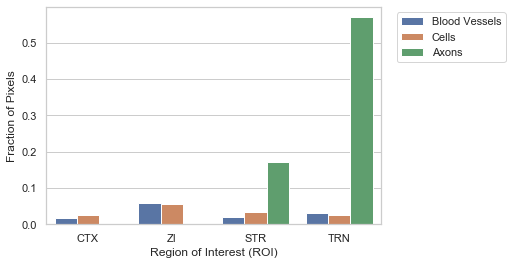

In [10]:
f = plt.figure()
sns.barplot(data=df,x="Region of Interest (ROI)",y="Fraction of Pixels",hue="Component")
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))

### 4. KL divergence between pixel intensity histograms (Fig. 2D)

In [11]:
hist_ctx_pdf = (hist_ctx + 1e-6)/sum(hist_ctx + 1e-6)
hist_str_pdf = (hist_str + 1e-6)/sum(hist_str + 1e-6)
hist_trn_pdf = (hist_trn + 1e-6)/sum(hist_trn + 1e-6)
hist_zi_pdf = (hist_zi + 1e-6)/sum(hist_zi + 1e-6)

pdfs_mat = np.zeros((4,len(hist_ctx_pdf)))
pdfs_mat[0] = hist_ctx_pdf
pdfs_mat[1] = hist_str_pdf
pdfs_mat[2] = hist_trn_pdf
pdfs_mat[3] = hist_zi_pdf

In [12]:
kl_mat = np.zeros((4,4))

for ii in range(4):
    for jj in range(4):
        kl_mat[ii,jj] = entropy(pdfs_mat[ii],pdfs_mat[jj])

In [13]:
kl_mat_new = matrix_rearrange(kl_mat)

Text(0.5, 1, 'KL Divergence (Intensity Histograms)')

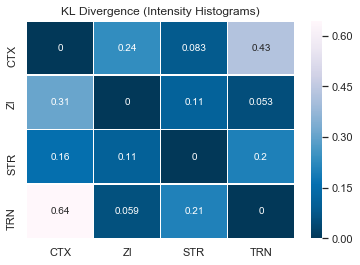

In [14]:
ff = plt.figure(1)
ax = sns.heatmap(kl_mat_new,annot=True,linewidths=0.5,cmap='PuBu_r',
            xticklabels=['CTX','ZI','STR','TRN'],yticklabels=['CTX','ZI','STR','TRN'])
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('KL Divergence (Intensity Histograms)')

### 5. KL divergence between microstructure distributions (Fig. 2E)

In [15]:
hist_all_areas_composition_ax_bv_ce = hist_all_areas_composition[:,1:]

In [16]:
composition_normed = np.zeros(hist_all_areas_composition_ax_bv_ce.shape)
for ii in range(4):
    composition_normed[ii] = hist_all_areas_composition_ax_bv_ce[ii]/norm(hist_all_areas_composition_ax_bv_ce[ii])
similarity = np.matmul(composition_normed,composition_normed.T)

In [17]:
similarity_inv = np.around(1-similarity,3)

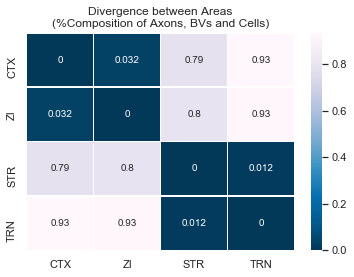

In [18]:
fig = plt.figure(1)
ax = sns.heatmap(similarity_inv,linewidths=0.5,cmap='PuBu_r',annot=True)
plt.title('Divergence between Areas\n(%Composition of Axons, BVs and Cells)')
plt.xticks((0.5,1.5,2.5,3.5),('CTX','ZI','STR','TRN'))
plt.yticks((0.5,1.5,2.5,3.5),('CTX','ZI','STR','TRN'))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

### 6. Inter-rater reliability (Fig. 3B-C)

In [19]:
IRR1_ans_key = np.load('irr/IRR1_ans_key.npy')
IRR2_ans_key = np.load('irr/IRR2_ans_key.npy')

In [20]:
preds_IRR1_annot1 = np.load('irr/IRR1_annot1.npy')
preds_IRR1_annot2 = np.load('irr/IRR1_annot2.npy')
preds_IRR2_annot1 = np.load('irr/IRR2_annot1.npy')
preds_IRR2_annot2 = np.load('irr/IRR2_annot2.npy')

In [21]:
classes = ['CTX','HYP','STR','VP','WM','ZI']

#### 6.1. Dataset 1

In [22]:
## annotator 1
print(classification_report(IRR1_ans_key,preds_IRR1_annot1,target_names=classes))

              precision    recall  f1-score   support

         CTX       0.88      0.93      0.90        30
         HYP       0.69      0.60      0.64        30
         STR       0.87      0.90      0.89        30
          VP       0.73      0.63      0.68        30
          WM       0.79      0.77      0.78        30
          ZI       0.72      0.87      0.79        30

    accuracy                           0.78       180
   macro avg       0.78      0.78      0.78       180
weighted avg       0.78      0.78      0.78       180



In [23]:
## annotator 2
print(classification_report(IRR1_ans_key,preds_IRR1_annot2,target_names=classes))

              precision    recall  f1-score   support

         CTX       0.93      0.93      0.93        30
         HYP       0.88      0.73      0.80        30
         STR       0.79      0.90      0.84        30
          VP       0.86      0.63      0.73        30
          WM       0.85      0.97      0.91        30
          ZI       0.80      0.93      0.86        30

    accuracy                           0.85       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.85      0.85      0.85       180



#### 6.2. Dataset 2

In [24]:
## annotator 1
print(classification_report(IRR2_ans_key,preds_IRR2_annot1,target_names=classes))

              precision    recall  f1-score   support

         CTX       0.93      0.87      0.90        30
         HYP       0.75      0.50      0.60        30
         STR       0.82      0.93      0.87        30
          VP       0.79      0.77      0.78        30
          WM       0.90      0.90      0.90        30
          ZI       0.72      0.93      0.81        30

    accuracy                           0.82       180
   macro avg       0.82      0.82      0.81       180
weighted avg       0.82      0.82      0.81       180



In [25]:
## annotator 2
print(classification_report(IRR2_ans_key,preds_IRR2_annot2,target_names=classes))

              precision    recall  f1-score   support

         CTX       0.90      0.93      0.92        30
         HYP       0.85      0.77      0.81        30
         STR       0.79      1.00      0.88        30
          VP       0.86      0.63      0.73        30
          WM       0.78      0.93      0.85        30
          ZI       0.77      0.67      0.71        30

    accuracy                           0.82       180
   macro avg       0.83      0.82      0.82       180
weighted avg       0.83      0.82      0.82       180



#### 6.3. Create dataframe that consolidates annotators' f1-scores across datasets

In [26]:
data = {'Region of Interest (ROI)': ['CTX','HYPOTH','STR','VP','WM','ZI',
                 'CTX','HYPOTH','STR','VP','WM','ZI',
                 'CTX','HYPOTH','STR','VP','WM','ZI',
                 'CTX','HYPOTH','STR','VP','WM','ZI'],
          'Predictor':['Human 1','Human 1','Human 1','Human 1','Human 1','Human 1',
                       'Human 2','Human 2','Human 2','Human 2','Human 2','Human 2',
                       'Human 1','Human 1','Human 1','Human 1','Human 1','Human 1',
                       'Human 2','Human 2','Human 2','Human 2','Human 2','Human 2'],
           'F1 Score':[0.90,0.64,0.89,0.68,0.78,0.79,
                    0.93,0.80,0.84,0.73,0.91,0.86,
                    0.90,0.60,0.87,0.78,0.90,0.81,
                    0.92,0.81,0.88,0.73,0.85,0.71],
          'Dataset':['1','1','1','1','1','1',
                     '1','1','1','1','1','1',
                     '2','2','2','2','2','2',
                     '2','2','2','2','2','2']}

df = pd.DataFrame.from_dict(data)

#### 6.4. Performance across areas

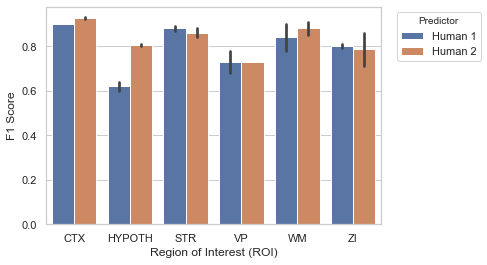

In [27]:
f = plt.figure()
x = "Region of Interest (ROI)"
y = "F1 Score"
hue = "Predictor"
ax = sns.barplot(data=df, x=x, y=y, hue=hue)

plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1), title=hue)
plt.show()